In [30]:
import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# these are the fifteen malware classes we're looking for
malware_classes = ["Agent", "AutoRun", "FraudLoad", "FraudPack", "Hupigon", "Krap",
           "Lipler", "Magania", "None", "Poison", "Swizzor", "Tdss",
           "VB", "Virut", "Zbot"]

# a function for writing predictions in the required format
def write_predictions(predictions, ids, outfile):
    """
    assumes len(predictions) == len(ids), and that predictions[i] is the
    index of the predicted class with the malware_classes list above for 
    the executable corresponding to ids[i].
    outfile will be overwritten
    """
    with open(outfile,"w+") as f:
        # write header
        f.write("Id,Prediction\n")
        for i, history_id in enumerate(ids):
            f.write("%s,%d\n" % (history_id, predictions[i]))

In [4]:
import pandas as pd

ids_classes = []
trees = []
for fname in os.listdir('train'):
    if fname == '.DS_Store':
        continue
    id_str, clazz = fname.split('.')[:2]
    ids_classes.append((id_str, clazz))
    tree = ET.parse(os.path.join('train', fname))
    trees.append(tree)

train_df = pd.DataFrame.from_records(ids_classes, columns=['id','class'])    

In [5]:
train_df.head()

,id,class
0,00269ea50001a6c699d0222032d45b74b2e7e8be9,None
1,00278ec420236020d6121dffe0cc20034422e7228,Lipler
2,002d5615d19c851934dc481c607b6a74a6e9e536e,VB
3,006be5Dc265600c19728c9747fb4c7bc9e8d6f106,None
4,0089453df77890cae95ce7d9130a4ef85eaea36e8,Swizzor


In [6]:
y = train_df['class'].values

In [7]:
def to_2class(classes):
    return ['None' if label == 'None' else 'Mal' for label in classes] 

In [8]:
not_calls = ['processes','all_section','thread','process']
docs = []
for tree in trees:
    calls = []
    for ele in tree.iter():
        if ele.tag not in not_calls:
            calls.append(ele.tag)   
    docs.append(calls)

In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
tfidf = vectorizer.fit_transform([' '.join(doc) for doc in docs])

In [10]:
X = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())

In [11]:
lr = LogisticRegression()

In [12]:
def classify_and_score(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    clf.fit(X_train, y_train)
    train_preds = clf.predict(X_train)
    print 'train accuracy: ' + str(metrics.accuracy_score(y_train, train_preds))
    test_preds = clf.predict(X_test)
    print 'validation accuracy: ' + str(metrics.accuracy_score(y_test, test_preds))
    return X_train, X_test, y_train, y_test

In [13]:
_ = classify_and_score(lr, X, y)

train accuracy: 0.823249783924
validation accuracy: 0.805699481865


In [14]:
rfc = RFC(n_estimators=50)
_ = classify_and_score(rfc, X, y)

train accuracy: 0.991356957649
validation accuracy: 0.897668393782


In [15]:
topfeats = rfc.feature_importances_.argsort()[-10:][::-1]
X.columns[topfeats]

Index([u'vm_write vm_protect vm_protect', u'get_system_directory enum_window',
       u'vm_allocate vm_protect create_thread_remote', u'vm_protect vm_write',
       u'get_host_by_name open_key', u'vm_write vm_allocate', u'vm_allocate',
       u'get_file_attributes get_windows_directory get_file_attributes',
       u'vm_write', u'enum_window'],
      dtype='object')

In [16]:
bottomfeats = rfc.feature_importances_.argsort()[:10][::-1]
X.columns[bottomfeats]

Index([u'load_dll listen_socket find_file',
       u'load_dll listen_socket create_socket',
       u'load_dll listen_socket create_mutex', u'load_dll listen_socket',
       u'load_dll kill_process set_file_attributes',
       u'load_dll kill_process open_key', u'load_dll kill_process load_image',
       u'load_dll kill_process load_dll',
       u'load_dll kill_process get_system_time', u'accept_socket'],
      dtype='object')

In [17]:
print X.shape
X_trans = rfc.transform(X)
print X_trans.shape

(3086, 15336)
(3086, 1486)


/Users/mr/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [22]:
_ = classify_and_score(rfc, X_trans, y)

train accuracy: 0.991789109767
validation accuracy: 0.89378238342


In [23]:
_ = classify_and_score(rfc, X_trans, to_2class(y))

train accuracy: 0.992653414002
validation accuracy: 0.936528497409


In [25]:
svm = LinearSVC()
_ = classify_and_score(svm, X_trans, y)

train accuracy: 0.87856525497
validation accuracy: 0.839378238342


In [26]:
from sklearn.grid_search import GridSearchCV

In [28]:
param_grid = {'n_estimators':[50, 100, 200, 500]}
gs_rfc = GridSearchCV(rfc, param_grid)

In [29]:
gs_rfc.fit(X_trans, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [36]:
def plot_grid_scores(grid_scores, param_name, log=False):
    params =  [model.parameters[param_name] for model in grid_scores]
    scores = [model.mean_validation_score for model in grid_scores]
    plt.plot(params, scores)
    if log:
        plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('accuracy')
    plt.show()

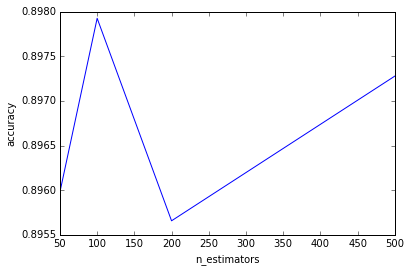

In [37]:
plot_grid_scores(gs_rfc.grid_scores_, 'n_estimators')